# Introduction
We assembled thoracic radiotherapy planning CT scans from 150 patients with locally advanced non-small cell lung cancer at Penn Radiation Oncology for primary GTV segmentation. The dataset is not publicly available.

## Imports
**Task: Import the necessary libraries**

* Pathlib for easy path handling
* nibabel as the files are provided in the NIfTI format
* numpy for data saving and processing
* matplotlib for plotting
* celluloid for nice volume visualization
* tqdm for nice progressing bars
* cv2 for resizing

In [1]:
%matplotlib notebook
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from tqdm.notebook import tqdm
import cv2

## Inspection:
**Task: Define the paths to images and labels for training**

In [2]:
from pathlib import Path

# Root of your split structure
BASE = Path(r"E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split")

# Where the CV folds live (according to your screenshot)
FOLDS_ROOT = BASE / "splits" / "train"    # contains fold0, fold1, ..., fold4

# Where the set-aside test set lives (adjust if your layout is different)
TEST_ROOT  = BASE / "splits" / "test"     # expected to contain image/, label_gtvp/

if not FOLDS_ROOT.exists():
    raise FileNotFoundError(f"Folds folder not found: {FOLDS_ROOT}")

def find_niis(root: Path):
    """Return all .nii.gz and .nii under root."""
    if not root.exists():
        return []
    nii_gz = list(root.rglob("*.nii.gz"))
    nii    = list(root.rglob("*.nii"))
    return sorted(nii_gz + nii)

NUM_FOLDS = 5

# Dicts to keep paths if you want to use them later
fold_train_images  = {}
fold_train_labels  = {}
fold_val_images    = {}
fold_val_labels    = {}

for fold_idx in range(NUM_FOLDS):
    fold_name = f"fold{fold_idx}"
    fold_dir  = FOLDS_ROOT / fold_name

    train_dir = fold_dir / "train"
    val_dir   = fold_dir / "val"

    # ---- train ----
    train_img_dir = train_dir / "image"
    train_lab_dir = train_dir / "label_gtvp"

    train_imgs = find_niis(train_img_dir)
    train_labs = find_niis(train_lab_dir)

    fold_train_images[fold_idx] = train_imgs
    fold_train_labels[fold_idx] = train_labs

    # ---- val ----
    val_img_dir = val_dir / "image"
    val_lab_dir = val_dir / "label_gtvp"

    val_imgs = find_niis(val_img_dir)
    val_labs = find_niis(val_lab_dir)

    fold_val_images[fold_idx] = val_imgs
    fold_val_labels[fold_idx] = val_labs

    # ---- print summary ----
    print(f"\n===== {fold_name} =====")
    print(f"train: {len(train_imgs)} images, {len(train_labs)} labels")
    for p in train_imgs[:3]:
        print("  train image:", p)
    for p in train_labs[:3]:
        print("  train label:", p)

    print(f"val:   {len(val_imgs)} images, {len(val_labs)} labels")
    for p in val_imgs[:3]:
        print("  val image:  ", p)
    for p in val_labs[:3]:
        print("  val label:  ", p)

# ---------- set-aside test set ----------
print("\n===== test (set-aside) =====")

test_img_dir = TEST_ROOT / "image"
test_lab_dir = TEST_ROOT / "label_gtvp"

test_images = find_niis(test_img_dir)
test_labels = find_niis(test_lab_dir)

print(f"test: {len(test_images)} images, {len(test_labels)} labels")
for p in test_images[:3]:
    print("  test image:", p)
for p in test_labels[:3]:
    print("  test label:", p)

# Example: sample path from fold0 train images
if fold_train_images.get(0):
    sample_path = fold_train_images[0][0]
    print("\nSample train image from fold0:", sample_path)


===== fold0 =====
train: 88 images, 88 labels
  train image: E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\splits\train\fold0\train\image\Lung_014_0000.nii.gz
  train image: E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\splits\train\fold0\train\image\Lung_026_0000.nii.gz
  train image: E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\splits\train\fold0\train\image\Lung_029_0000.nii.gz
  train label: E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\splits\train\fold0\train\label_gtvp\Lung_014.nii.gz
  train label: E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\splits\train\fold0\train\label_gtvp\Lung_026.nii.gz
  train label: E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\splits\train\fold0\train\label_gtvp\Lung_029.nii.gz
val:   22 images, 22 labels
  val image:   E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\splits\train\fold0\val\image\Lung_008_0000.nii.gz
  val image:   E:\DoNotTouch\projects\LANSCLC

In [3]:
from pathlib import Path

BASE = Path(r"E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split")

fold_idx  = 0                       # change 0 -> 1,2,3,4 for other folds
fold_name = f"fold{fold_idx}"

train_root = BASE / "splits" / "train" / fold_name / "train"

images = list((train_root / "image").rglob("*.nii.gz"))
labels = list((train_root / "label_gtvp").rglob("*.nii.gz"))

print(f"{fold_name} train images:", len(images), " | train labels:", len(labels))

fold0 train images: 88  | train labels: 88


**Task: Load a sample NIfTI and its corresponding label mask**

In [4]:
from pathlib import Path
import re

def change_img_to_label_path(img_path: Path) -> Path:
    img_path = Path(img_path)

    # Expect .../<split>/<image>/<file>
    if img_path.parent.name != "image":
        raise ValueError(f"Expected parent folder 'image', got: {img_path.parent}")

    # Swap ".../image" -> ".../label_gtvp"
    label_dir = img_path.parent.with_name("label_gtvp")

    # Remove only the final "_0000" before extension
    new_name = re.sub(r'_0000(?=\.nii(\.gz)?$)', '', img_path.name)

    return label_dir / new_name

In [5]:
# images: List[Path]  (e.g. from train_root / "image")
candidates = [p for p in images if p.name.startswith("Lung")]
if len(candidates) < 3:
    raise IndexError(f"Only {len(candidates)} files match 'Lung*'")

sample_path = candidates[2]   # 3rd match
sample_path_label = change_img_to_label_path(sample_path)

In [6]:
sample_path, sample_path_label

(WindowsPath('E:/DoNotTouch/projects/LANSCLC/CIS_5810/selected_150_split/splits/train/fold0/train/image/Lung_029_0000.nii.gz'),
 WindowsPath('E:/DoNotTouch/projects/LANSCLC/CIS_5810/selected_150_split/splits/train/fold0/train/label_gtvp/Lung_029.nii.gz'))

### Load NIfTI and extract image data

In [8]:
import nibabel as nib

data = nib.load(sample_path)
label = nib.load(sample_path_label)

ct = data.get_fdata()
mask = label.get_fdata()

**Task: Find out the orientation**

In [9]:
nib.aff2axcodes(data.affine) # In Part 2, I mistakenly planned to use RAS; in Part 3, I’ll correct this to LPS. We’ll only convert to RAS if a specific tool requires it (typically some neuroimaging tools).

('L', 'P', 'S')

**Task: Inspect the loaded data with overlaid Ground Truth tumor segmentation**

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import HTML, display

def reorient(slice2d: np.ndarray) -> np.ndarray:
    s = np.flipud(slice2d)
    s = np.rot90(s, k=3)
    return s

fig, ax = plt.subplots(figsize=(6, 6))
camera = Camera(fig)

for i in range(0, ct.shape[2], 2):  # axial slices
    ct_i   = reorient(ct[:, :, i])
    mask_i = reorient(mask[:, :, i])

    ax.imshow(ct_i, cmap="bone", interpolation="nearest")
    ax.imshow(
        np.ma.masked_where(mask_i == 0, mask_i),
        alpha=0.5, cmap="autumn", interpolation="nearest"
    )
    ax.set_axis_off()
    camera.snap()

anim = camera.animate(interval=180, blit=False, repeat=True, repeat_delay=800)

# show inline as HTML5 video
display(HTML(anim.to_html5_video()))
plt.close(fig)  # avoid extra blank static figure

## Preprocessing
**Task: Perform the following preprocessing steps:**

1. CT images have a fixed range from -1000 to 3071. **Thus we normalize by dividing by 3071** <br /> We don't need to compute mean and standard deviation for this task
2. As we want to focus on lung tumors, we can crop away parts of the lower abdomen to reduce the complexity and help the network learn. As an example, **we skip the first 20 slices (from lower abdomen to the neck)** (last axis)
3. As we want to tackle this task on a slice level (2D) and not on a subject level (3D) to reduce the computational cost **we store the preprocessed data as 2d files**, because reading a single slice is much faster than loading the complete NIfTI file.
4. Resize the single slices and masks to (256, 256) (when resizing the mask, pass interpolation=cv2.INTER_NEAREST to the resize function to apply nearest neighbour interpolation)

Loop over all_files and apply the preprocessing steps. <br />

In the preprocessing loop, you need to create a directory for each subject containg the ct and label slices with identical names. <br />
E.g:
* 0/data/0.npy
* 0/masks/0.npy

In [27]:
from pathlib import Path
import re

# Base of your split directory
BASE = Path(r"E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split")

FOLDS_ROOT = BASE / "splits" / "train"   # contains fold0..fold4
TEST_ROOT  = BASE / "splits" / "test"    # contains image/, label_gtvp/

def change_img_to_label_path(img_path: Path) -> Path:
    """
    Map .../image/Lung_xxx_0000.nii.gz -> .../label_gtvp/Lung_xxx.nii.gz
    """
    img_path = Path(img_path)
    if img_path.parent.name != "image":
        raise ValueError(f"Expected parent folder 'image', got: {img_path.parent}")

    # swap .../image -> .../label_gtvp
    label_dir = img_path.parent.with_name("label_gtvp")
    # remove only the final "_0000" before extension
    new_name = re.sub(r'_0000(?=\.nii(\.gz)?$)', '', img_path.name)
    return label_dir / new_name

def case_id_from_img_path(p: Path) -> str:
    """
    Extract a case ID from file name, e.g.
      Lung_0123_0000.nii.gz -> Lung_0123
      Lung_0123.nii.gz      -> Lung_0123
    """
    name = p.name
    name = re.sub(r'\.nii(\.gz)?$', '', name)  # drop extension
    name = re.sub(r'_0000$', '', name)         # drop final patch index
    return name

def collect_pairs(split_dir: Path):
    """
    Return (image_path, label_path) pairs for a split directory that has:
      split_dir / "image"
      split_dir / "label_gtvp"
    """
    img_dir = split_dir / "image"
    if not img_dir.exists():
        print(f"[WARN] image folder not found: {img_dir}")
        return []

    img_paths = sorted(img_dir.rglob("*.nii*"))
    pairs = []
    for ip in img_paths:
        lp = change_img_to_label_path(ip)
        if lp.exists():
            pairs.append((ip, lp))
        else:
            print(f"WARNING ({split_dir}): missing label for {ip.name}")
    return pairs

NUM_FOLDS = 5

# dicts keyed by fold name: "fold0", "fold1", ...
pairs_train = {}
pairs_val   = {}

for fold_idx in range(NUM_FOLDS):
    fold_name = f"fold{fold_idx}"
    fold_dir  = FOLDS_ROOT / fold_name

    train_dir = fold_dir / "train"
    val_dir   = fold_dir / "val"

    pairs_train[fold_name] = collect_pairs(train_dir)
    pairs_val[fold_name]   = collect_pairs(val_dir)

# set-aside test set (no folds)
pairs_test = collect_pairs(TEST_ROOT)

# ---- summary ----
for fold_name in pairs_train:
    print(f"{fold_name}: train={len(pairs_train[fold_name])} | val={len(pairs_val[fold_name])}")

print(f"\nTest set: {len(pairs_test)} pairs")

# key: case_id (e.g. "Lung_0123"), value: (img_path, lbl_path)
pairs_all_dict = {}

# add all CV folds, but keep each case only once
for fold_name in pairs_train:
    for ip, lp in pairs_train[fold_name] + pairs_val[fold_name]:
        cid = case_id_from_img_path(ip)
        if cid not in pairs_all_dict:
            pairs_all_dict[cid] = (ip, lp)

# add test set (optionally warn if overlapping with CV)
for ip, lp in pairs_test:
    cid = case_id_from_img_path(ip)
    if cid in pairs_all_dict:
        print(f"[WARN] test case {cid} already present in CV folds")
    else:
        pairs_all_dict[cid] = (ip, lp)

# final unique list
pairs_all = list(pairs_all_dict.values())
print("Unique cases over all folds + test:", len(pairs_all))

# Optional: peek a few from one fold and test
for name, pairs in [("fold0/train", pairs_train["fold0"]),
                    ("fold0/val",   pairs_val["fold0"]),
                    ("test",        pairs_test)]:
    print(f"\n{name} preview:")
    for i, (ip, lp) in enumerate(pairs[:3]):
        print(f"  [{i}] img: {ip.name}  |  lbl: {lp.name}")

fold0: train=88 | val=22
fold1: train=88 | val=22
fold2: train=88 | val=22
fold3: train=88 | val=22
fold4: train=88 | val=22

Test set: 40 pairs
Unique cases over all folds + test: 150

fold0/train preview:
  [0] img: Lung_014_0000.nii.gz  |  lbl: Lung_014.nii.gz
  [1] img: Lung_026_0000.nii.gz  |  lbl: Lung_026.nii.gz
  [2] img: Lung_029_0000.nii.gz  |  lbl: Lung_029.nii.gz

fold0/val preview:
  [0] img: Lung_008_0000.nii.gz  |  lbl: Lung_008.nii.gz
  [1] img: Lung_036_0000.nii.gz  |  lbl: Lung_036.nii.gz
  [2] img: Lung_056_0000.nii.gz  |  lbl: Lung_056.nii.gz

test preview:
  [0] img: Lung_054_0000.nii.gz  |  lbl: Lung_054.nii.gz
  [1] img: Lung_062_0000.nii.gz  |  lbl: Lung_062.nii.gz
  [2] img: Lung_065_0000.nii.gz  |  lbl: Lung_065.nii.gz


In [28]:
from pathlib import Path
from fnmatch import fnmatch

all_files = [img for (img, lbl) in pairs_all if fnmatch(img.name, "Lung_*")]
print(len(all_files), "matches")

150 matches


In [31]:
# ====== MAIN ======
save_root.mkdir(parents=True, exist_ok=True)

n_train = n_val = n_test = 0

splits_root = BASE / "splits"

# collect ALL CT files from all folds + test (only those in "image" dirs)
ct_files = sorted(
    p for p in splits_root.rglob("*.nii*")
    if p.parent.name == "image"   # ensure it's really an image, not label
)

print(f"Found {len(ct_files)} CT volumes under {splits_root}")

from tqdm import tqdm

for path_to_ct_data in tqdm(ct_files, desc="Preprocessing"):
    path_to_ct_data = Path(path_to_ct_data)

    # Determine where this case lives (train/val/test + fold) from its original path
    try:
        rel = path_to_ct_data.relative_to(splits_root)
        # e.g. rel = 'train/fold0/train/image/Lung_0123_0000.nii.gz'
        parts = rel.parts
    except ValueError:
        print(f"[Skip] {path_to_ct_data} is not under {splits_root}")
        continue

    # Determine split type just for counting (optional)
    # Example parts: ('train', 'fold0', 'train', 'image', 'Lung_0123_0000.nii.gz')
    split_type = None
    if parts[0] == "train":
        if len(parts) >= 3:
            split_type = parts[2]  # 'train' or 'val'
    elif parts[0] == "test":
        split_type = "test"

    if split_type == "train":
        n_train += 1
    elif split_type == "val":
        n_val += 1
    elif split_type == "test":
        n_test += 1

    # Matching label path
    path_to_label = change_img_to_label_path(path_to_ct_data)
    has_label = path_to_label.exists()

    # --- Load volumes ---
    ct_img = nib.load(path_to_ct_data)
    ct_vol = np.array(ct_img.get_fdata(dtype=np.float32), dtype=np.float32, copy=False)  # (H,W,D)

    if has_label:
        lbl_img = nib.load(path_to_label)
        lbl_vol = np.array(lbl_img.get_fdata(dtype=np.float32), dtype=np.float32, copy=False)

    # --- Optional depth crop ---
    if ct_vol.shape[-1] > 20:
        ct_vol = ct_vol[:, :, 20:]
        if has_label:
            lbl_vol = lbl_vol[:, :, 20:]

    # Scale (HU -> normalized) and sanitize
    ct_vol = ct_vol / 3071.0
    ct_vol = np.nan_to_num(ct_vol, nan=0.0, posinf=0.0, neginf=0.0)
    if has_label:
        lbl_vol = np.nan_to_num(lbl_vol, nan=0.0, posinf=0.0, neginf=0.0)

    D = int(ct_vol.shape[-1])
    if D == 0:
        print(f"[Skip] No slices after crop: {path_to_ct_data}")
        continue

    # --- Build destination dirs mirroring original structure ---
    # Original: BASE/splits/.../<image or label_gtvp>/Lung_0123_0000.nii.gz
    # Target:   BASE/Preprocessed_for_2D_Unet/splits/.../image/Lung_0123/<slice>.npy
    #           BASE/Preprocessed_for_2D_Unet/splits/.../label_gtvp/Lung_0123/<slice>.npy

    case_id = case_id_from_img_path(path_to_ct_data)

    rel_parent = rel.parent             # e.g. 'train/fold0/train/image'
    dest_img_case_dir = save_root / rel_parent / case_id
    dest_img_case_dir.mkdir(parents=True, exist_ok=True)

    dest_lbl_case_dir = None
    if has_label:
        dest_lbl_case_dir = dest_img_case_dir.parent.with_name("label_gtvp") / case_id
        dest_lbl_case_dir.mkdir(parents=True, exist_ok=True)

    # --- Slice-wise save ---
    for i in range(D):
        slc = scipy_resize2d(ct_vol[:, :, i], TARGET_HW, order=1)
        safe_np_save(dest_img_case_dir / f"{i}", slc)

        if has_label:
            msk = scipy_resize2d(lbl_vol[:, :, i], TARGET_HW, order=0)
            safe_np_save(dest_lbl_case_dir / f"{i}", msk)

print(f"Saved cases -> train: {n_train} | val: {n_val} | test: {n_test}")
print("Output root:", save_root)

Found 590 CT volumes under E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\splits


Preprocessing: 100%|█████████████████████████████████████████████████████████████████| 590/590 [32:42<00:00,  3.33s/it]

Saved cases -> train: 440 | val: 110 | test: 40
Output root: E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits


# Validate preprocessed data
**Task: Take a look at stored files and inspect if everything worked as expected**

In [36]:
# pick a fold and a case ID (folder name under image/)
fold_name = "fold0"          # or "fold1", ..., "fold4"
case_id   = "Lung_014"      # replace with an actual case folder

path = (
    BASE
    / "Preprocessed_for_2D_Unet"
    / "splits"
    / "train"
    / fold_name
    / "train"
#     / "image"
#     / case_id
)  # subject folder with slice .npy files

print(path)

E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold0\train


In [37]:
list(path.glob("*"))

[WindowsPath('E:/DoNotTouch/projects/LANSCLC/CIS_5810/selected_150_split/Preprocessed_for_2D_Unet/splits/train/fold0/train/image'),
 WindowsPath('E:/DoNotTouch/projects/LANSCLC/CIS_5810/selected_150_split/Preprocessed_for_2D_Unet/splits/train/fold0/train/label_gtvp')]

In [39]:
file = "36.npy"
slice = np.load(path/"image"/case_id/file)
mask = np.load(path/"label_gtvp"/case_id/file)

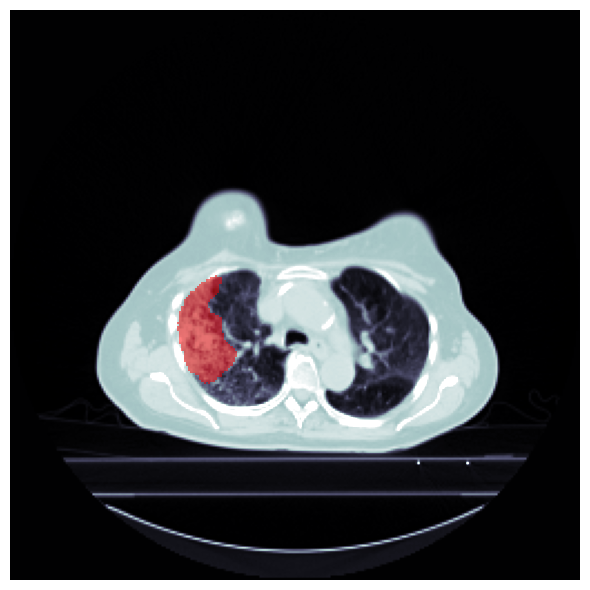

In [40]:
# 1) Ensure inline backend
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

def reorient_2d(a: np.ndarray) -> np.ndarray:
    return np.rot90(np.flipud(a), k=3)  # flip TB, rotate -90° (clockwise)

# slc, msk must be 2D arrays
slc = np.asarray(slice)      # your CT slice
msk = np.asarray(mask)       # your mask (0/1)

# safety checks
assert slc.ndim == 2 and msk.ndim == 2, (slc.shape, msk.shape)
assert slc.shape == msk.shape, "slice/mask shapes must match"

# reorient
slc_r = reorient_2d(slc)
msk_r = reorient_2d(msk)

# robust window
vmin, vmax = np.percentile(slc_r, [1, 99])
if not np.isfinite(vmin) or not np.isfinite(vmax) or vmax <= vmin:
    vmin, vmax = float(np.nanmin(slc_r)), float(np.nanmax(slc_r))

# 2) Make and show the figure (no global close, no clear_output)
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(slc_r, cmap="bone", vmin=vmin, vmax=vmax)
ax.imshow(np.ma.masked_where(msk_r == 0, msk_r), cmap="autumn", alpha=0.5, interpolation="nearest")
ax.axis("off")
fig.tight_layout()
plt.show()            # <-- explicitly show
plt.close(fig)        # close just this figure

In [41]:
print(slice.min(), slice.max())

-0.33296686 0.42111865
